# EhV Quality control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from ehv.core import plot_gate_zarr, plot_gate_zarr_channels
from ehv.masking import plot_scip_segmentation

In [4]:
from umap import UMAP
import time
import math
import pyarrow.parquet as pq
from scip.masking import threshold
from scip.masking import util
from scip.features import texture
import zarr
import flowutils

## SCIP computed features

## Load processed frame

In [5]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/features.parquet").to_pandas()

In [13]:
df = pq.read_table("/srv/scratch/maximl/data/ehv/results/scip/202202071958/features.parquet").to_pandas()

In [6]:
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)

In [7]:
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])

## No bounding box

In [8]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(131783, 1291)

In [9]:
df.filter(regex="feat").shape

(131783, 1277)

## Number of identified regions per channel 

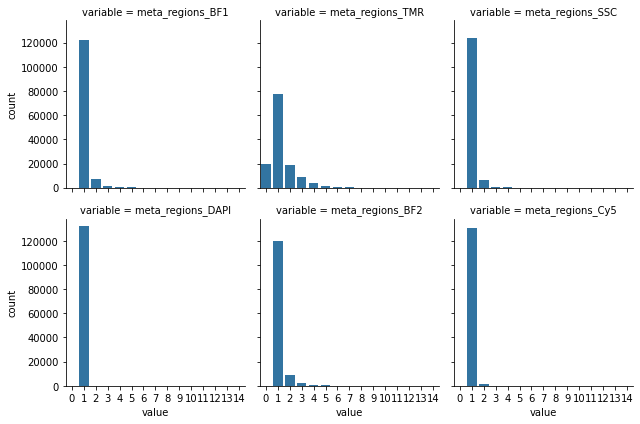

In [10]:
tmp = pandas.melt(df.reset_index(), value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype(int).astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable", col_wrap=3)
grid.map_dataframe(seaborn.countplot, x="value")
plt.savefig("number_of_regions.png")

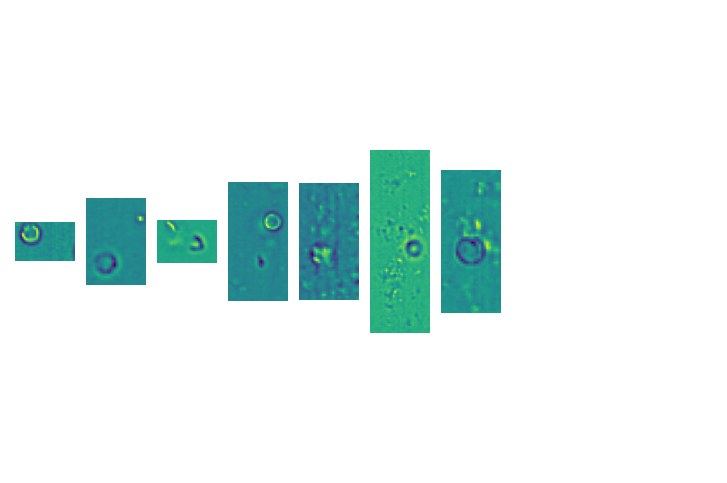

In [11]:
sel = df["meta_regions_BF1"] != 1
plot_gate_zarr(sel, df, maxn=7)

In [12]:
sel = ((df["meta_regions_BF1"] == 1) & (df["meta_regions_BF2"] == 1))

In [13]:
df = df[sel]
df.shape

(116839, 1291)

## NaN values

In [14]:
# show all NaN columns
df.columns[df.isna().all(axis=0)]

Index([], dtype='object')

# All cells must have strictly positive SSC and BF area

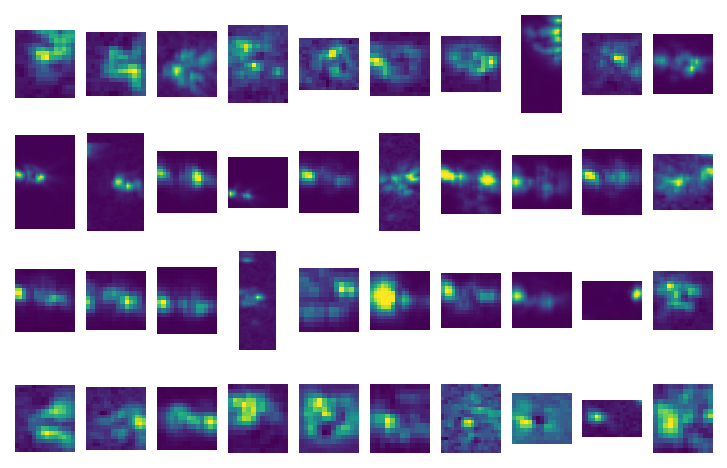

In [17]:
sel1 = df["feat_area_SSC"] == 0
core.plot_gate_zarr(sel1, df, channel=3, maxn=40)

In [18]:
df = df[~sel1]
df.shape

(115383, 1291)

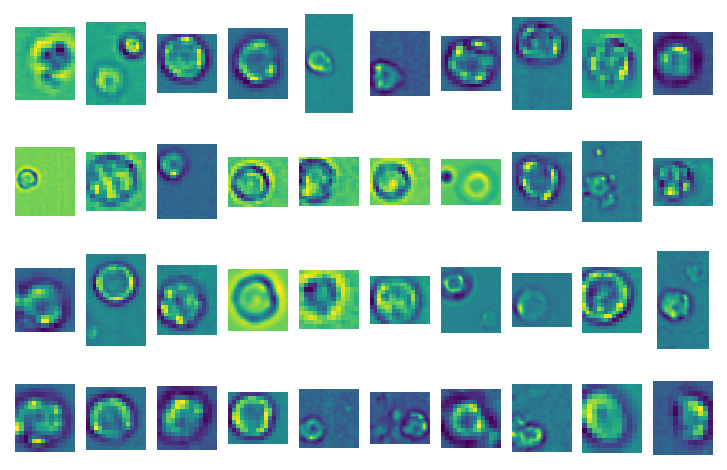

In [20]:
sel1 = df["feat_area_BF1"] == 0
core.plot_gate_zarr(sel1, df, channel=0, maxn=40)

In [21]:
df = df[~sel1]
df.shape

(114835, 1291)

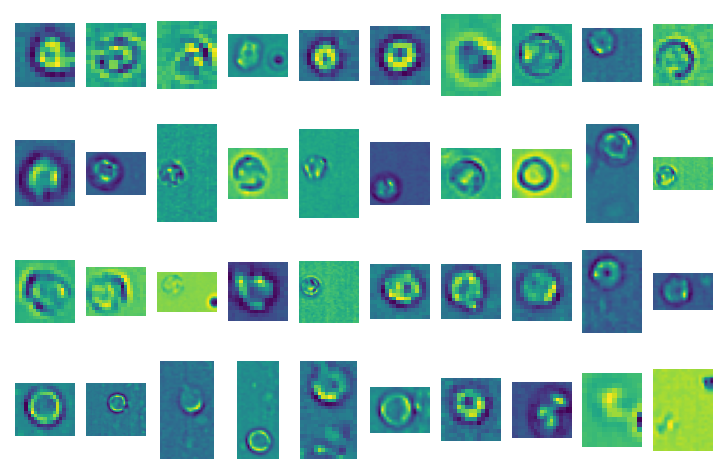

In [22]:
sel1 = df["feat_area_BF2"] == 0
core.plot_gate_zarr(sel1, df, channel=0, maxn=40)

In [23]:
df = df[~sel1]
df.shape

(114621, 1291)

# Detecting multiplets that are missed during segmentation

<AxesSubplot:xlabel='feat_major_axis_length_BF1', ylabel='feat_minor_axis_length_BF1'>

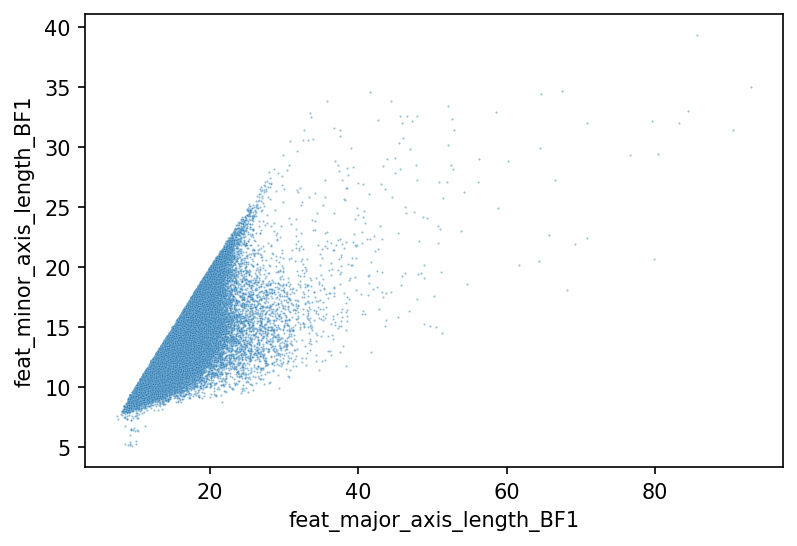

In [24]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_BF1", y="feat_minor_axis_length_BF1", s=1, alpha=0.5, edgecolors="none")

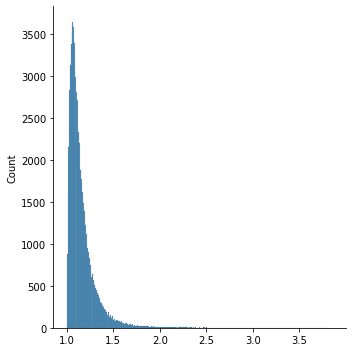

In [25]:
feat_majorminor_ratio = df["feat_major_axis_length_BF1"] / df["feat_minor_axis_length_BF1"]
ax = seaborn.displot(x=feat_majorminor_ratio)

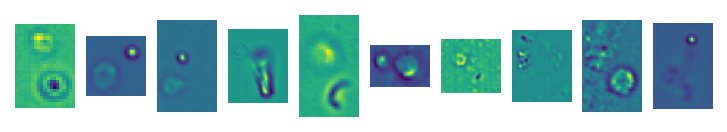

In [26]:
sel1 = feat_majorminor_ratio > 2
plot_gate_zarr(sel1, df, maxn=10)

In [27]:
df = df[~sel1]
df.shape

(114015, 1291)

<AxesSubplot:xlabel='feat_major_axis_length_TMR', ylabel='Count'>

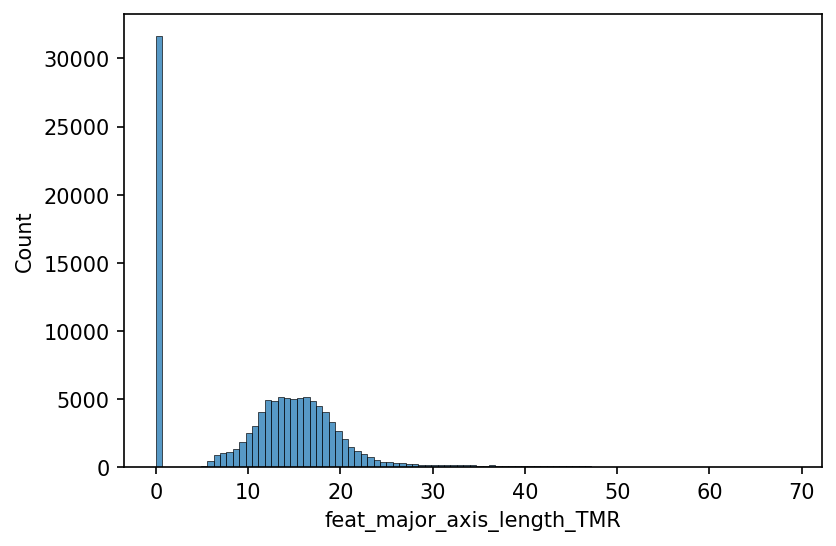

In [28]:
fig, ax = plt.subplots(dpi=150)
seaborn.histplot(ax=ax, data=df, x="feat_major_axis_length_TMR")

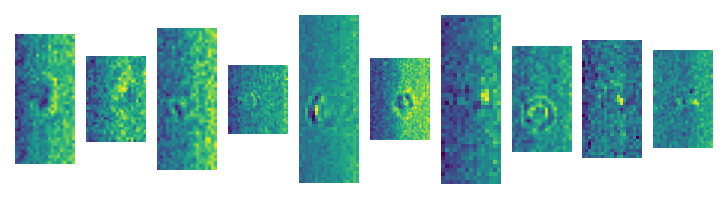

In [29]:
sel1 = df["feat_major_axis_length_TMR"] > 30
plot_gate_zarr(sel1, df, maxn=10, channel=1)

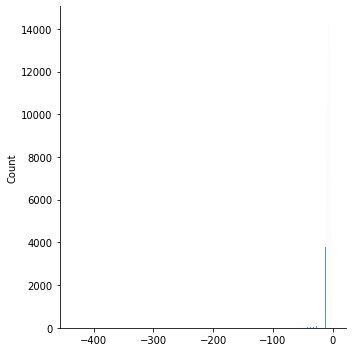

In [30]:
seaborn.displot(data=df["feat_area_BF1"] - df["feat_convex_area_BF1"])

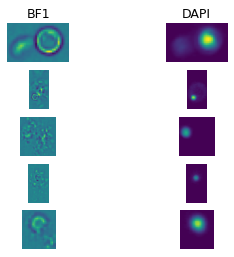

In [31]:
sel1 = (df["feat_area_BF1"] - df["feat_convex_area_BF1"]) < -50
core.plot_gate_zarr_channels([sel1], df, maxn=5, main_channel=1, smooth=1, channel_ind=[0, 4], channel_names=["BF1", "DAPI"])

In [32]:
df = df[~sel1]
df.shape

(113618, 1291)

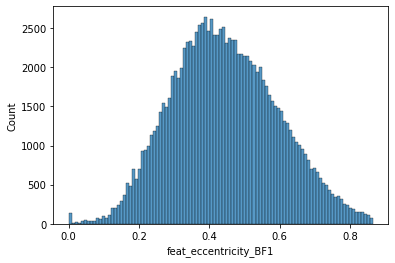

In [33]:
ax = seaborn.histplot(data=df, x="feat_eccentricity_BF1")

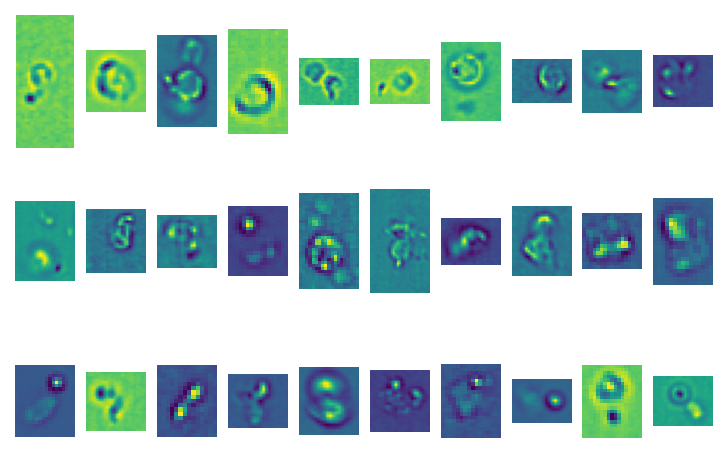

In [34]:
sel1 = df["feat_eccentricity_BF1"] > 0.75
core.plot_gate_zarr(sel1, df, maxn=30)

In [35]:
df = df[~sel1]
df.shape

(110740, 1291)

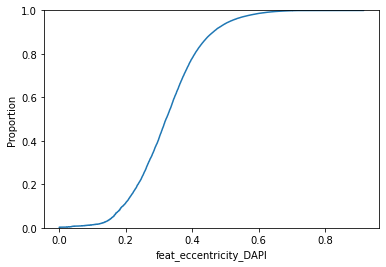

In [36]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_DAPI")

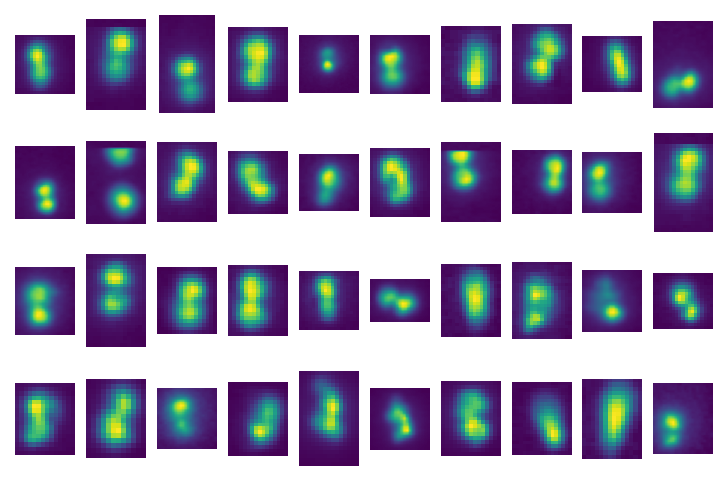

In [37]:
sel1 = df["feat_eccentricity_DAPI"] > 0.7
core.plot_gate_zarr(sel1, df, channel=4, maxn=40)

In [38]:
df = df[~sel1]
df.shape

(110619, 1291)

# Texture features

<AxesSubplot:xlabel='feat_glcm_mean_homogeneity_5_BF1', ylabel='feat_area_BF1'>

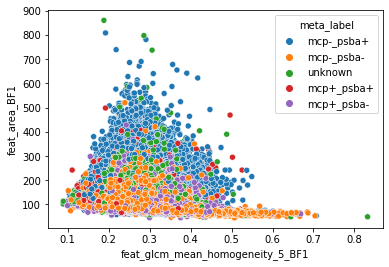

In [31]:
seaborn.scatterplot(data=df, x="feat_glcm_mean_homogeneity_5_BF1", y="feat_area_BF1", hue="meta_label")

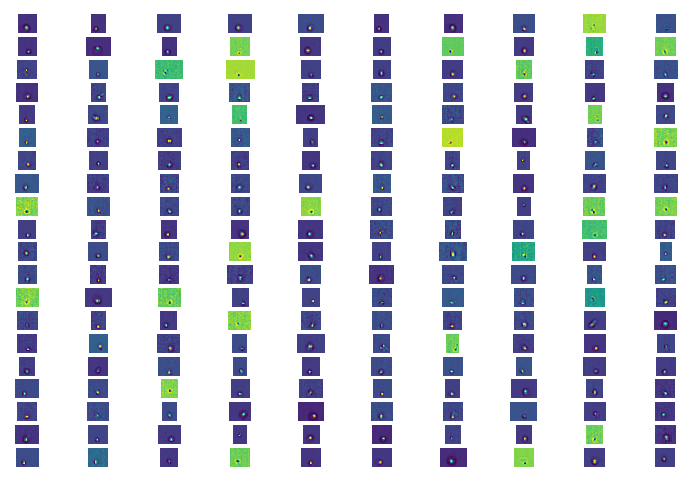

In [53]:
sel1 = df["feat_glcm_mean_homogeneity_5_BF1"] > 0.5
core.plot_gate_zarr(sel1, df)

In [345]:
df[sel1]["meta_label"].value_counts()

mcp-_psba-    168
mcp+_psba-     46
mcp-_psba+     43
unknown        20
mcp+_psba+      1
Name: meta_label, dtype: int64

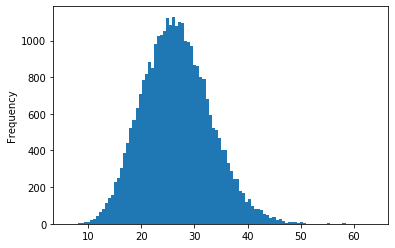

In [54]:
df["feat_glcm_mean_contrast_3_BF1"].plot.hist(bins=100)

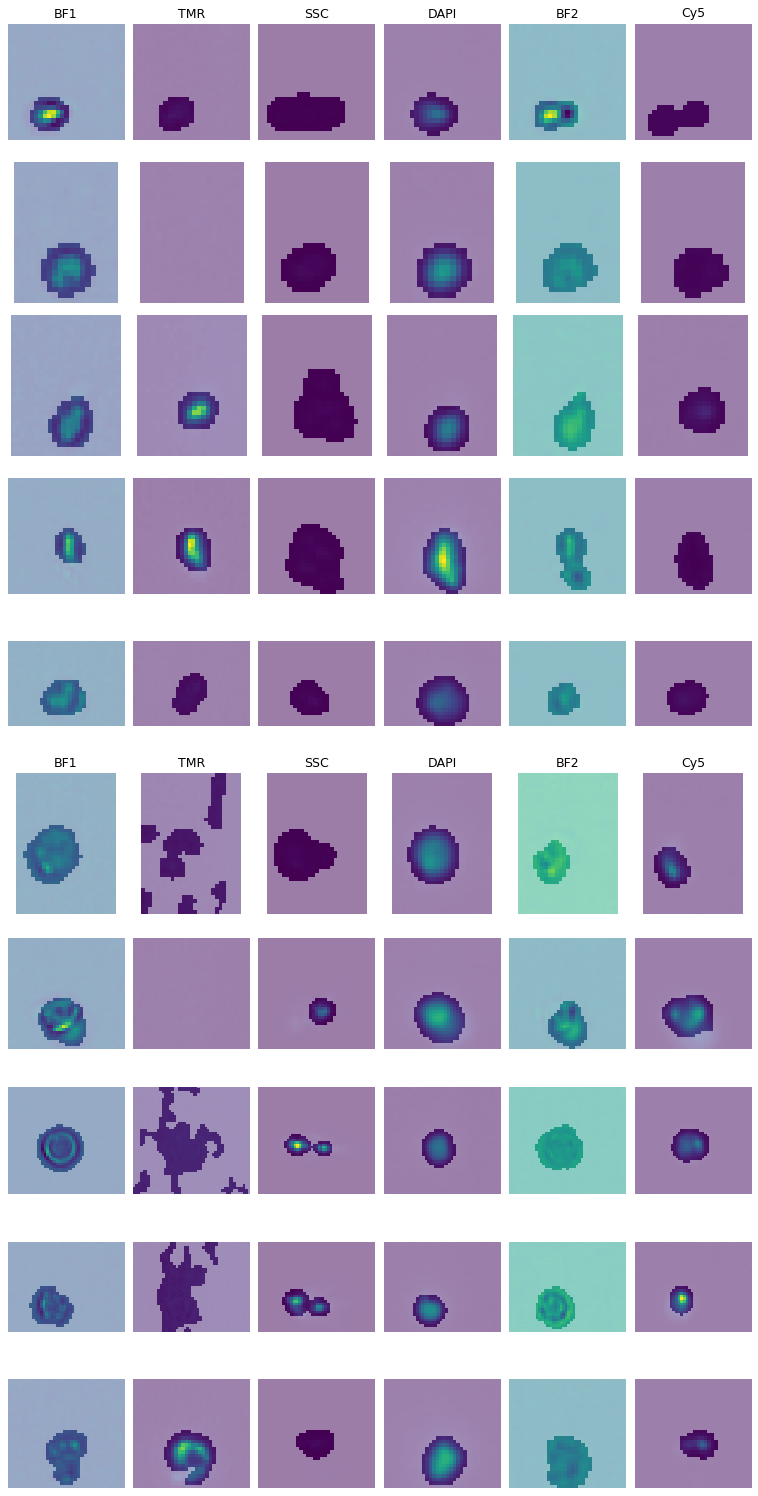

In [347]:
sel1 = df["feat_glcm_mean_contrast_3_BF1"] > 40
sel2 = df["feat_glcm_mean_contrast_3_BF1"] < 10
plot_gate_zarr_channels([sel1, sel2], df, maxn=5, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

# Outlier features or rows

### Inter-quartile range

In [35]:
cols, amount = [], []
for col in df.drop(columns=df.filter(regex="(TMR|Cy5)$")).filter(regex="feat"):
    q1, q3 = numpy.percentile(df[col], [25, 75])
    cutoff = q3 + (q3-q1)*1.5
    a = (df[col] > cutoff).sum()
    if a > 0:
        cols.append(col)
        amount.append(a)
        
amount = numpy.array(amount)
cols = numpy.array(cols)

In [36]:
len(cols)

694

(array([206., 172., 128., 108.,  63.,   6.,   2.,   3.,   3.,   3.]),
 array([1.0000e+00, 2.3020e+03, 4.6030e+03, 6.9040e+03, 9.2050e+03,
        1.1506e+04, 1.3807e+04, 1.6108e+04, 1.8409e+04, 2.0710e+04,
        2.3011e+04]),
 <BarContainer object of 10 artists>)

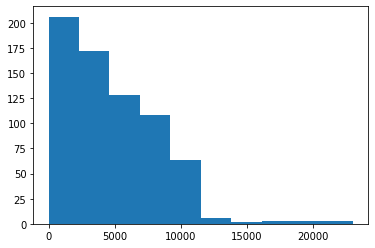

In [37]:
plt.hist(amount)

In [38]:
tmp = cols[numpy.where(amount > 12000)]

In [39]:
tmp[0]

'feat_moments_hu-3_combined'

<AxesSubplot:>

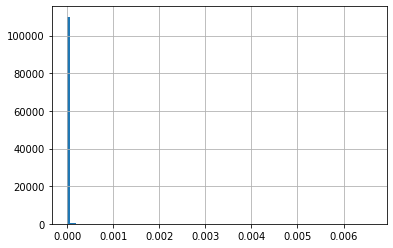

In [40]:
df[tmp[0]].hist(bins=100)

<AxesSubplot:>

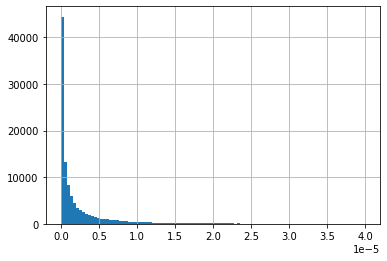

In [64]:
df[df[tmp[0]] < 0.00004][tmp[0]].hist(bins=100)

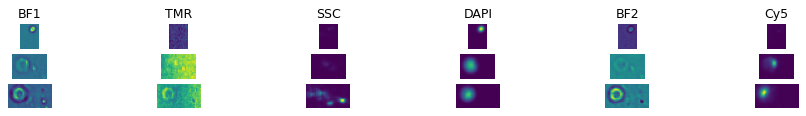

In [42]:
sel1 = df[tmp[0]] > 0.001
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [43]:
tmp[1]

'feat_moments_hu-4_combined'

<AxesSubplot:>

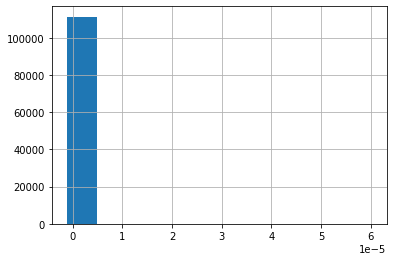

In [44]:
df[tmp[1]].hist()

In [61]:
df[tmp[1]].describe()

count    1.113570e+05
mean     5.517283e-09
std      2.678869e-07
min     -1.151847e-06
25%     -1.131321e-15
50%      8.281076e-13
75%      2.921945e-11
max      6.013206e-05
Name: feat_moments_hu-4_combined, dtype: float64

<AxesSubplot:ylabel='Frequency'>

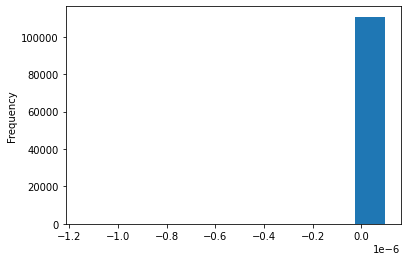

In [60]:
df[df[tmp[1]] < 1e-7][tmp[1]].plot.hist()

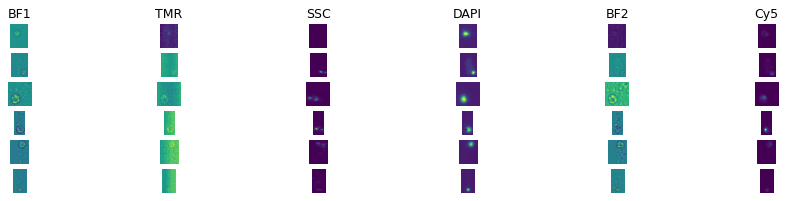

In [55]:
sel1 = df[tmp[1]] > 1e-5
plot_gate_zarr_channels([sel1], df, maxn=10, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

### Normalized variance

In [46]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

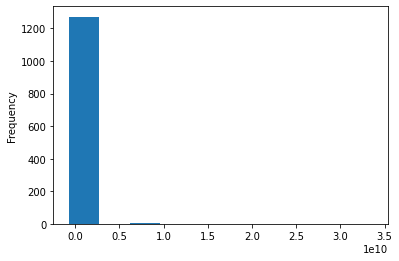

In [47]:
norm_var.plot.hist()

In [48]:
inf_features = norm_var[norm_var.abs() == numpy.inf]

In [49]:
inf_features

Series([], dtype: float64)

In [50]:
for f in inf_features.index:
    s = len(df)
    v = df[f].var()
    while abs(v) == numpy.inf:
        if abs(df[f].min()) > abs(df[f].max()):
            df = df.drop(index=df[f].idxmin())
        else:
            df = df.drop(index=df[f].idxmax())
        v = df[f].var()
    print("Dropped %d rows for %s" % (s-len(df), f))

In [51]:
norm_var[norm_var > 1e10]

feat_moments-3-3_TMR            2.311314e+10
feat_moments_central-3-3_TMR    3.368987e+10
dtype: float64

<AxesSubplot:ylabel='Frequency'>

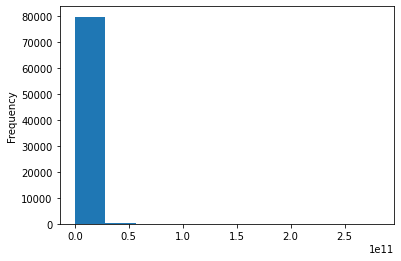

In [52]:
df["feat_moments-3-3_TMR"].plot.hist()

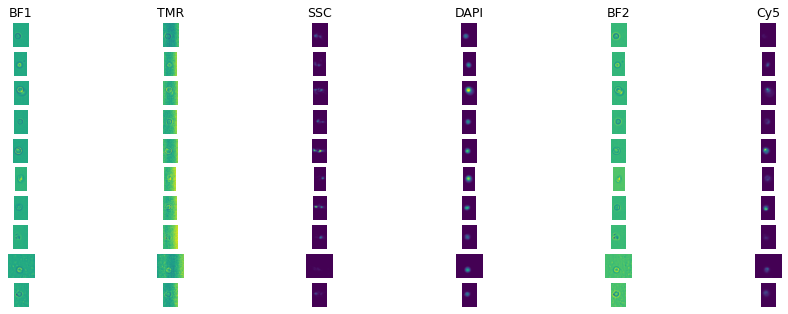

In [54]:
sel1 = df["feat_moments-3-3_TMR"] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=10, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [47]:
df = df[~sel1]
df.shape

(112733, 1130)

In [48]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

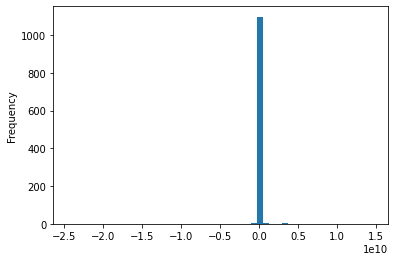

In [49]:
norm_var.plot.hist(bins=50)

In [50]:
norm_var[norm_var > 1e10]

feat_moments-3-3_TMR    1.459468e+10
dtype: float64

<AxesSubplot:ylabel='Frequency'>

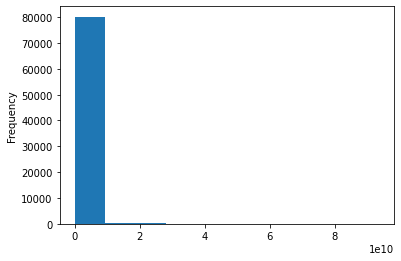

In [51]:
df["feat_moments-3-3_TMR"].plot.hist()

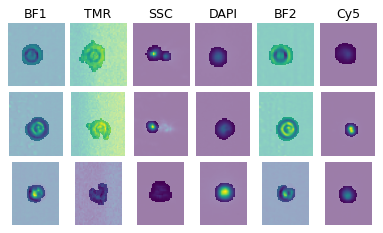

In [52]:
sel1 = df["feat_moments-3-3_TMR"] > 1e10
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [53]:
sel1.sum()

692

In [54]:
df = df[~sel1]
df.shape

(112041, 1130)

In [55]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

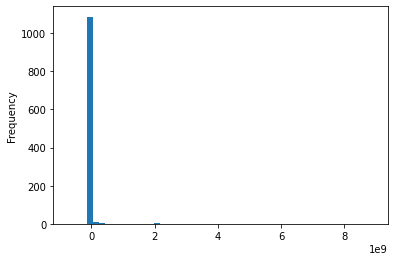

In [56]:
norm_var.plot.hist(bins=50)

In [57]:
norm_var[norm_var > 1e9]

feat_moments-3-3_combined       6.023222e+09
feat_moments-3-3_TMR            2.746597e+09
feat_moments-3-3_SSC            2.098211e+09
feat_moments-3-3_BF2            8.902491e+09
feat_moments_central-3-2_BF2    2.107739e+09
feat_moments-3-3_Cy5            2.554276e+09
dtype: float64

In [58]:
df = df.drop(columns=df.filter(regex="moments-3-3").columns)

In [59]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

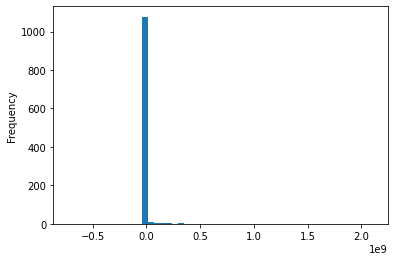

In [60]:
norm_var.plot.hist(bins=50)

In [61]:
norm_var[norm_var > 1e9]

feat_moments_central-3-2_BF2    2.107739e+09
dtype: float64

In [62]:
df = df.drop(columns=df.filter(regex="moments").columns)

In [63]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

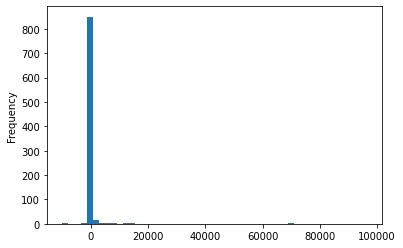

In [64]:
norm_var.plot.hist(bins=50)

In [65]:
norm_var[norm_var > 60000]

feat_sum_SSC                    68923.964801
feat_bgcorr_sum_SSC             78214.991503
feat_combined_sum_SSC           69748.976272
feat_combined_bgcorr_sum_SSC    81171.194601
feat_bgcorr_edge_sum_BF2        96353.681780
dtype: float64

<AxesSubplot:ylabel='Frequency'>

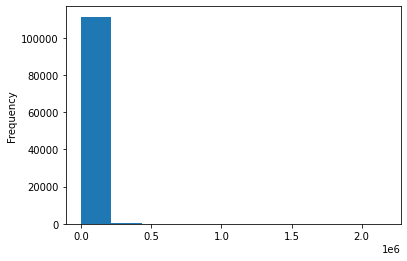

In [66]:
df["feat_sum_SSC"].plot.hist()

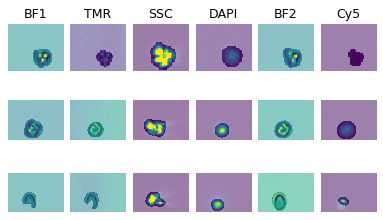

In [106]:
sel1 = df["feat_sum_SSC"] > 400000
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

### Isolation forest

In [76]:
from sklearn.ensemble import IsolationForest

In [77]:
iso = IsolationForest(n_estimators=100, random_state=0, n_jobs=5, contamination=0.05)
iso.fit(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

/data/gent/420/vsc42015/python_lib/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, n_jobs=5, random_state=0)

In [78]:
pred = iso.predict(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

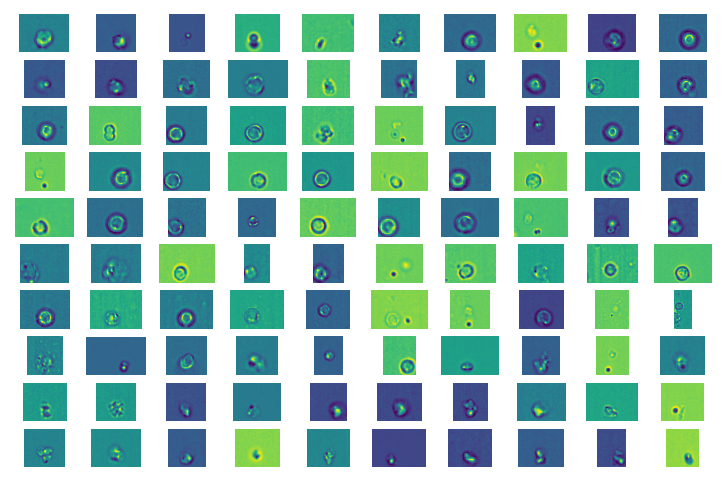

In [100]:
plot_gate_zarr(pred == -1, df, maxn=100)

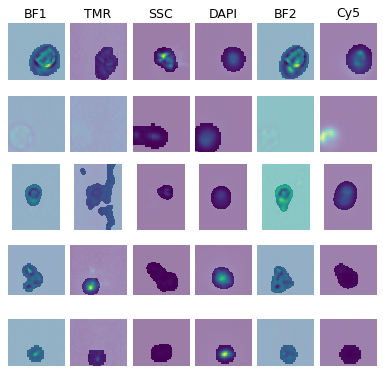

In [132]:
plot_gate_zarr_channels([pred == -1], df, maxn=5, smooth=1, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [71]:
numpy.unique(pred, return_counts=True)

(array([-1,  1]), array([  5602, 106439]))

# Feature distributions

In [129]:
df = df.loc[numpy.load("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/index.npy", allow_pickle=True)]
df = df[numpy.load("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/columns.npy", allow_pickle=True)]

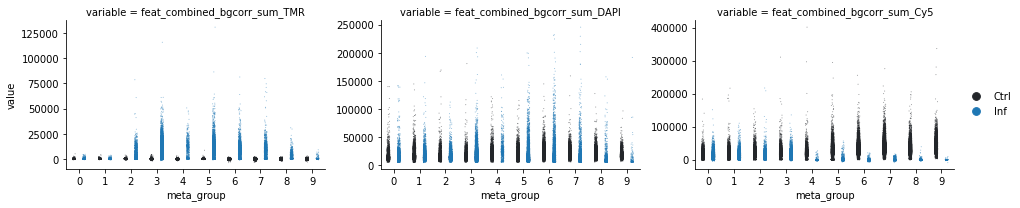

In [97]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="feat_combined_bgcorr_sum_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [116]:
for k, gdf in df.groupby("meta_group"):
    gdf = gdf[[
        "feat_combined_bgcorr_sum_TMR", 
        "feat_combined_bgcorr_sum_DAPI", 
        "feat_combined_bgcorr_sum_Cy5"
    ]]
    transf = flowutils.transforms.logicle(gdf.values, w=1.3, t=200000, m=4.5, channel_indices=None)
    df.loc[(slice(None), slice(None), slice(None), slice(None), k), [
        "feat_combined_bgcorr_sum_logicle_TMR",
        "feat_combined_bgcorr_sum_logicle_DAPI", 
        "feat_combined_bgcorr_sum_logicle_Cy5"
    ]] = transf

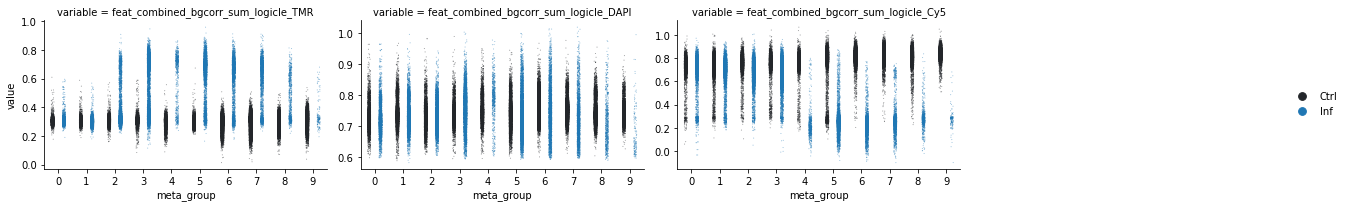

In [117]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="feat_combined_bgcorr_sum_logicle_(TMR|DAPI|Cy5)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [125]:
df[pred == -1].index.get_level_values("meta_type").value_counts()

Ctrl    3668
Inf     1970
Name: meta_type, dtype: int64

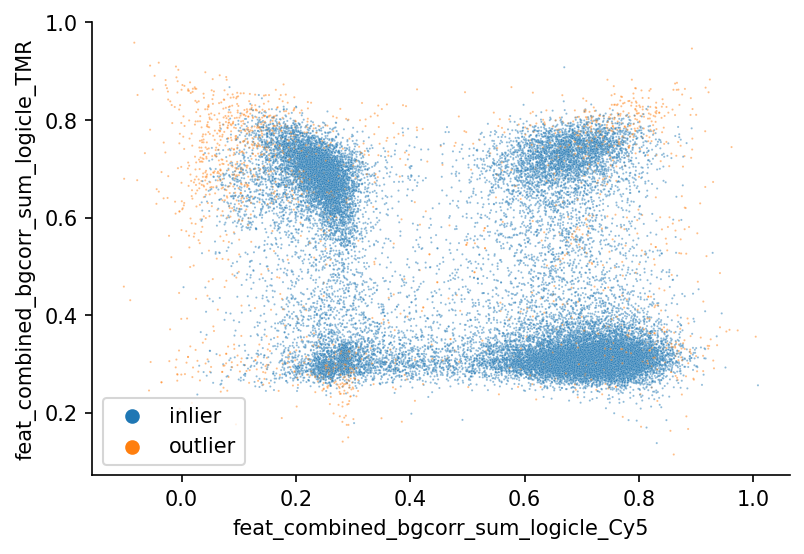

In [128]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(
    data=df.loc["Inf"], 
    x="feat_combined_bgcorr_sum_logicle_Cy5", 
    y="feat_combined_bgcorr_sum_logicle_TMR", 
    hue=numpy.where(pred[numpy.nonzero(df.index.get_level_values(level="meta_type") == "Inf")] == 1, "inlier", "outlier"), 
    s=1, alpha=0.5, ax=ax
)
seaborn.despine(fig)

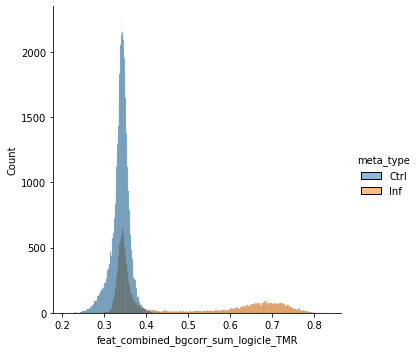

In [89]:
seaborn.displot(data=df, x="feat_combined_bgcorr_sum_logicle_TMR", hue="meta_type")

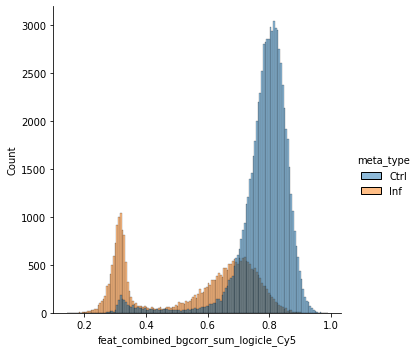

In [90]:
seaborn.displot(data=df, x="feat_combined_bgcorr_sum_logicle_Cy5", hue="meta_type")

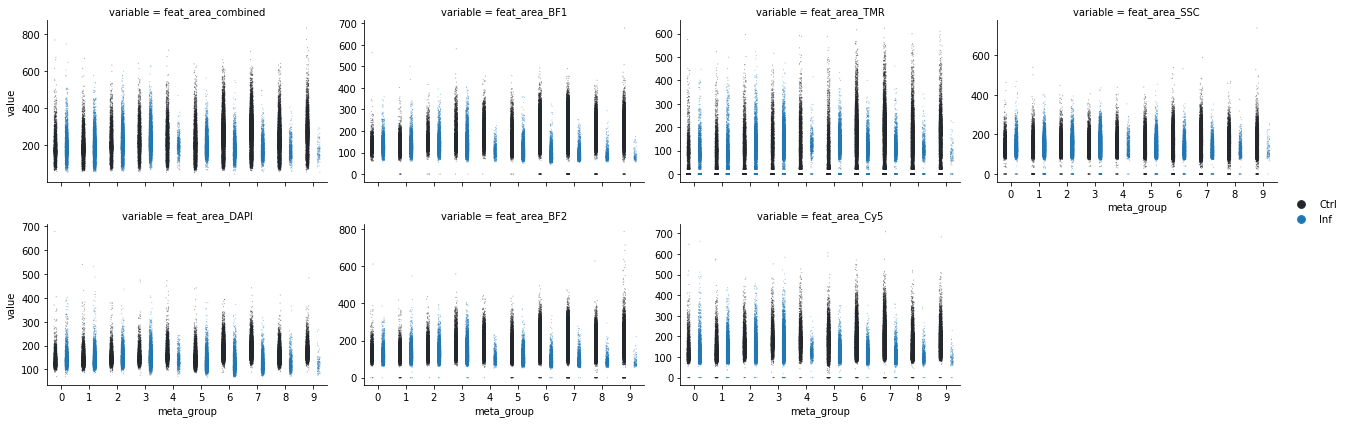

In [18]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="^feat_area_.*").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5, col_wrap=4)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [76]:
df = df[pred == 1]

# Low variance features

In [39]:
v = df.filter(regex="feat").var()

In [40]:
v.isna().sum()

0

In [41]:
low_var = df.filter(regex="feat").columns[df.filter(regex="feat").var() < 0.001]

In [42]:
low_var

Index(['feat_euler_number_combined', 'feat_solidity_combined',
       'feat_moments_central-0-1_combined',
       'feat_moments_central-1-0_combined', 'feat_moments_hu-0_combined',
       'feat_moments_hu-1_combined', 'feat_moments_hu-2_combined',
       'feat_moments_hu-3_combined', 'feat_moments_hu-4_combined',
       'feat_moments_hu-5_combined',
       ...
       'feat_glcm_mean_ASM_3_Cy5', 'feat_glcm_mean_ASM_5_Cy5',
       'feat_glcm_std_ASM_3_Cy5', 'feat_glcm_std_ASM_5_Cy5',
       'feat_combined_glcm_std_homogeneity_3_Cy5',
       'feat_combined_glcm_std_homogeneity_5_Cy5',
       'feat_combined_glcm_std_energy_3_Cy5',
       'feat_combined_glcm_std_energy_5_Cy5',
       'feat_combined_glcm_std_ASM_3_Cy5', 'feat_combined_glcm_std_ASM_5_Cy5'],
      dtype='object', length=173)

In [43]:
df = df.drop(columns=low_var)

# Export

In [44]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/index_v3.npy", df.index.values)

In [45]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202202071958/columns_v3.npy", df.columns.values)